In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import os

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

# CONFIGURATION
NUM_AGENTS = 5
BATCH_SIZE = 50
EPOCHS = 1
ROUNDS = 50
LR = 0.001
LAMBDA_STAR = 0.87
TRAIN_SIZE_PER_AGENT = 8000
VAL_RATIO = 0.2
FIG_DIR = "./figures_exp02"
os.makedirs(FIG_DIR, exist_ok=True)

# Small CNN for MNIST
class SmallConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

# Load MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Custom non-IID partition with fixed size per agent
def partition_balanced_non_iid(dataset, class_map, train_size=8000, val_ratio=0.2):
    label_to_indices = {label: [] for label in range(10)}
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)

    agent_train_loaders = []
    agent_val_loaders = []
    agent_val_indices_all = []

    total_per_agent = int(train_size / (1 - val_ratio))  # total = train + val
    samples_per_class = total_per_agent // 2

    for agent_classes in class_map:
        indices = []
        for label in agent_classes:
            label_indices = label_to_indices[label]
            np.random.shuffle(label_indices)
            selected = label_indices[:samples_per_class]
            indices.extend(selected)
        np.random.shuffle(indices)

        val_size = int(val_ratio * len(indices))
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]

        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

        agent_train_loaders.append(train_loader)
        agent_val_loaders.append(val_loader)
        agent_val_indices_all.extend(val_indices)

        print(f"Agent with classes {agent_classes}:")
        print(f"  Training samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

    val_loader_global = DataLoader(Subset(dataset, agent_val_indices_all), batch_size=BATCH_SIZE, shuffle=False)

    return agent_train_loaders, agent_val_loaders, val_loader_global

# Class distribution per agent
class_map = [
    [2, 8],  # Agent 1
    [4, 9],  # Agent 2
    [1, 6],  # Agent 3
    [3, 7],  # Agent 4
    [0, 5],  # Agent 5
]

train_loaders, val_loaders_local, val_loader_global = partition_balanced_non_iid(
    train_dataset, class_map, train_size=TRAIN_SIZE_PER_AGENT, val_ratio=VAL_RATIO
)

# Training function
def train(model, loader, lambda_star=LAMBDA_STAR):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=lambda_star * 1e-9)
    loss_fn = nn.CrossEntropyLoss()
    running_loss = 0
    total_batches = 0
    for _ in range(EPOCHS):
        for x, y in loader:
            optimizer.zero_grad()
            pred = model(x)
            ce_loss = loss_fn(pred, y)
            loss = (1 - lambda_star) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            total_batches += 1
    return running_loss / total_batches

# Evaluation function
def evaluate(model, loader, return_preds=False):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            pred = model(x)
            pred_labels = pred.argmax(1)
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    if return_preds:
        return accuracy, np.array(all_preds), np.array(all_labels)
    else:
        return accuracy

# Federated averaging
def federated_avg(models):
    global_model = SmallConvNet()
    global_dict = global_model.state_dict()
    for key in global_dict:
        global_dict[key] = torch.stack([m.state_dict()[key].float() for m in models], 0).mean(0)
    global_model.load_state_dict(global_dict)
    return global_model

Agent with classes [2, 8]:
  Training samples: 8000, Validation samples: 2000
Agent with classes [4, 9]:
  Training samples: 8000, Validation samples: 2000
Agent with classes [1, 6]:
  Training samples: 8000, Validation samples: 2000
Agent with classes [3, 7]:
  Training samples: 8000, Validation samples: 2000
Agent with classes [0, 5]:
  Training samples: 8000, Validation samples: 2000


In [6]:
LAMBDA_STAR = 0.00

# Initialize models and metrics
models = [SmallConvNet() for _ in range(NUM_AGENTS)]
agent_accuracies = [[] for _ in range(NUM_AGENTS)]
agent_losses = [[] for _ in range(NUM_AGENTS)]
agent_f1_scores = [[] for _ in range(NUM_AGENTS)]

# Federated training loop
for rnd in range(ROUNDS):
    print(f"\n--- Round {rnd + 1} ---")
    
    for i in range(NUM_AGENTS):
        loss = train(models[i], train_loaders[i], lambda_star=LAMBDA_STAR)
        agent_losses[i].append(loss)

    global_model = federated_avg(models)
    for i in range(NUM_AGENTS):
        models[i].load_state_dict(global_model.state_dict())

    # Local validation
    print("  [Local Validation (same classes per agent)]")
    for i in range(NUM_AGENTS):
        acc, preds, labels = evaluate(models[i], val_loaders_local[i], return_preds=True)
        f1 = f1_score(labels, preds, average='macro')
        agent_accuracies[i].append(acc)
        agent_f1_scores[i].append(f1)
        print(f"  Agent {i+1}: Accuracy={acc:.4f}, F1 Score={f1:.4f}")

# Final test evaluation
print("\n--- Final Evaluation on Test Set ---")
test_loader = DataLoader(test_dataset, batch_size=128)
test_acc, test_preds, test_labels = evaluate(global_model, test_loader, return_preds=True)
test_f1 = f1_score(test_labels, test_preds, average='macro')

print(f"\nGlobal Model Accuracy on Test Set: {test_acc:.4f}")
print(f"Global Model F1 Score on Test Set: {test_f1:.4f}")


--- Round 1 ---
  [Local Validation (same classes per agent)]
  Agent 1: Accuracy=0.0000, F1 Score=0.0000
  Agent 2: Accuracy=0.4995, F1 Score=0.3331
  Agent 3: Accuracy=0.0000, F1 Score=0.0000
  Agent 4: Accuracy=0.0000, F1 Score=0.0000
  Agent 5: Accuracy=0.0000, F1 Score=0.0000

--- Round 2 ---
  [Local Validation (same classes per agent)]
  Agent 1: Accuracy=0.0645, F1 Score=0.0441
  Agent 2: Accuracy=0.0000, F1 Score=0.0000
  Agent 3: Accuracy=0.3265, F1 Score=0.1861
  Agent 4: Accuracy=0.4940, F1 Score=0.1580
  Agent 5: Accuracy=0.0000, F1 Score=0.0000

--- Round 3 ---
  [Local Validation (same classes per agent)]
  Agent 1: Accuracy=0.0000, F1 Score=0.0000
  Agent 2: Accuracy=0.4860, F1 Score=0.1722
  Agent 3: Accuracy=0.2815, F1 Score=0.1689
  Agent 4: Accuracy=0.2860, F1 Score=0.1272
  Agent 5: Accuracy=0.1960, F1 Score=0.0704

--- Round 4 ---
  [Local Validation (same classes per agent)]
  Agent 1: Accuracy=0.2660, F1 Score=0.0920
  Agent 2: Accuracy=0.0560, F1 Score=0.0264


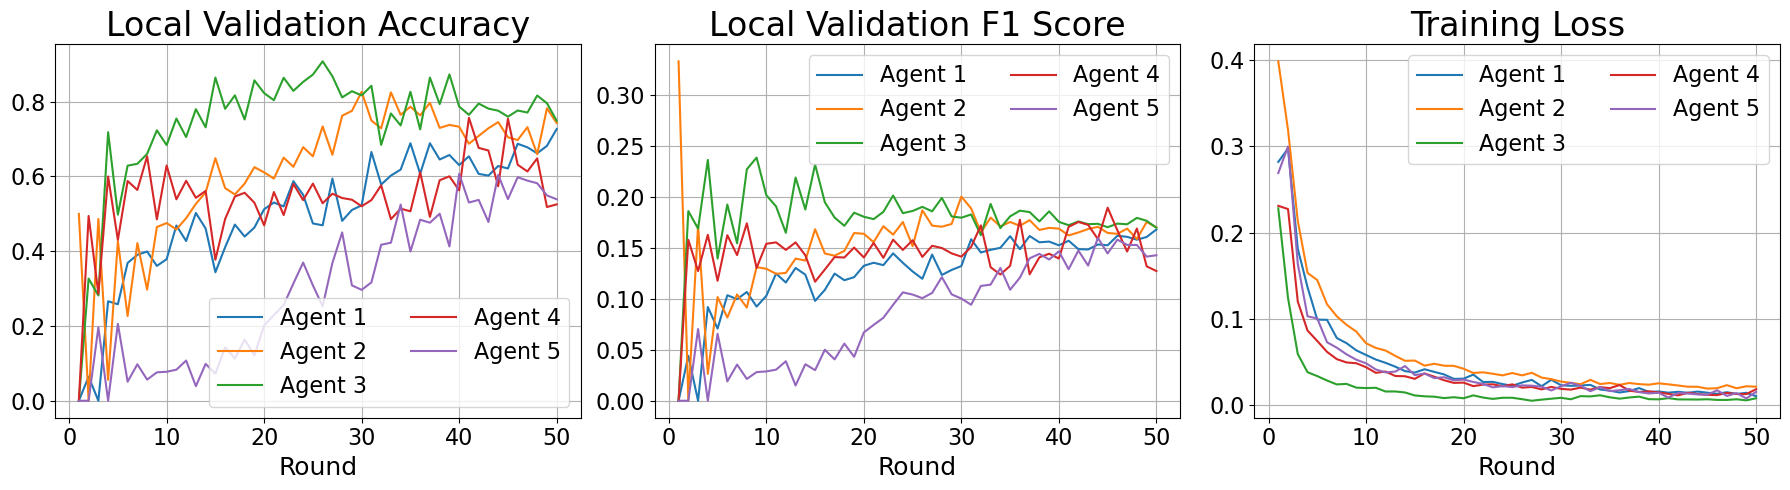

In [7]:
# --- Plotting ---
rounds = list(range(1, ROUNDS + 1))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i in range(NUM_AGENTS):
    axs[0].plot(rounds, agent_accuracies[i], label=f'Agent {i+1}')
    axs[1].plot(rounds, agent_f1_scores[i], label=f'Agent {i+1}')
    axs[2].plot(rounds, agent_losses[i], label=f'Agent {i+1}')

axs[0].set_title('Local Validation Accuracy', fontsize=24)
axs[0].tick_params(axis='both',labelsize=16)


axs[1].set_title('Local Validation F1 Score', fontsize=24)
axs[1].tick_params(axis='both',labelsize=16)

axs[2].set_title('Training Loss', fontsize=24)
axs[2].tick_params(axis='both',labelsize=16)

for ax in axs:
    ax.set_xlabel('Round', fontsize=18)
    ax.grid(True)
    ax.legend(fontsize=16, ncol=2)

#axs[0].set_ylabel('Accuracy')
#axs[1].set_ylabel('F1 Score')
#axs[2].set_ylabel('Loss')

plt.tight_layout()

# Dynamically generate filename
filename = f"training_metrics_summary_lambda{int(LAMBDA_STAR * 1000):03d}.pdf"
plt.savefig(os.path.join(FIG_DIR, filename), dpi=300)
plt.show()